In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit

import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes', labelsize=15)

%matplotlib inline

## Importando os dados da instituição

In [2]:
realizados = pd.read_csv('realizados.txt', sep='\t', decimal=',', header=0)

In [3]:
realizados.head()

,DAP,comprimento,altura,CQE,UM
0,16,34,165,56.4,2206
1,18,30,170,51.0,2241
2,18,30,170,51.0,2257
3,19,35,190,59.1,2279
4,19,38,190,63.3,2278


In [4]:
#realizados['DAP'].value_counts().plot.bar()

    Criar uma lista com varios pacientes
    Cada um cotem, em coluna os valores ALEATÓRIOS de DAP, altura e comprimento
    Executar a função monitor_unit para cada uma deles

In [5]:
#adress = "C:\\Users\\Pedro Henrique\\Desktop\\TBI_BIG_SSD"
#os.chdir(adress)

In [6]:
bd = pd.read_csv('bd.txt', sep="\t", decimal='.', header=0, index_col=0)
sp = pd.read_csv('sp.txt', sep="\t", decimal='.', header=0, index_col=0)
tpr = pd.read_csv('tpr.txt', sep="\t", decimal='.', header=0, index_col=0)

In [7]:
#map(lambda x:int(x),tpr.columns)
#map(lambda x:int(x),bd.columns)

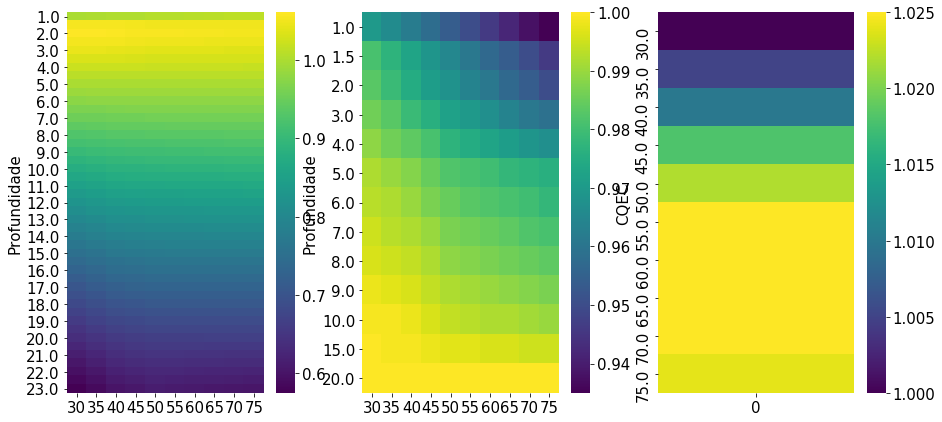

In [8]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.heatmap(tpr, cmap='viridis')
plt.subplot(1,3,2)
sns.heatmap(bd, cmap='viridis')
plt.subplot(1,3,3)
sns.heatmap(sp, cmap='viridis')

## Definindo função de criação pacientes virtuais com dimensões discretas em resolução

In [9]:
def newPatiente(number):
    DAP = np.random.randint(16,41, size=number)
    altura = np.random.randint(100,200, size=number)
    comprimento = np.random.randint(20,46, size=number)
    data = pd.DataFrame({'DAP':DAP,
                         'comprimento':comprimento,
                         'altura':altura})
    return data

## Definindo função de CQE

In [10]:
def cqe(altura,comprimento):
    return float(2*(altura*comprimento)/(altura+comprimento))

## Definindo as matrizes de interpolação

In [11]:
tprInterpol = interpolate.interp2d(tpr.columns.astype(float), tpr.index.astype(float), tpr, kind='linear',bounds_error=False)
bdInterpol = interpolate.interp2d(bd.columns.astype(float), bd.index.astype(float), bd, kind='linear', bounds_error=False)
spInterpol = interpolate.interp1d(sp.index.astype(float), sp['0'].astype(float), kind='linear', bounds_error=False, fill_value=(1,1.024))

## Definindo a função de cálculo de Unidade Monitoras

In [12]:
def monitor_unit(Dose_campo,SSD,DAP,altura,comprimento):
    #SAD padrão é 465cm
    IQD = (465/SSD)**2
    Sc = 1.106 #maior campo possível
    Sp = spInterpol(cqe(altura,comprimento))
    TPR = tprInterpol(cqe(altura,comprimento),0.5*DAP)
    BD = bdInterpol(cqe(altura,comprimento),0.5*DAP)
    Calib = 0.04334
    bandeija=0.9612
    #print("*****************************")
    #print("<> Sp:",Sp)
    #print("<> Sc:",Sc)
    #print("<> Calibracao:",Calib)
    #print("<> TPR:",TPR)
    #print("<> Biuld Down:",BD)
    #print("<> Correcao IQD:",IQD)
    #print("\n")
    #print("UM = ", round(um,0))   
    #print("---------------------------------------------")
    
    return float(Dose_campo/(Sc*Sp*TPR*BD*Calib*IQD))

## Simulando

In [13]:
dataPatiente = newPatiente(10000)
dataTBI = dataPatiente

CQE = []
UM = []

for i in dataPatiente.index:    
    CQE.append(cqe(dataPatiente['altura'][i],dataPatiente['comprimento'][i]))
    UM.append(monitor_unit(100,465,dataPatiente['DAP'][i],dataPatiente['altura'][i],dataPatiente['comprimento'][i]))
    
    #print('.', end=' ')
    #print("Paciente {} completo".format(i))

#TENTAR
#CQE = cqe(dataPatiente['altura'],dataPatiente['comprimento'])
#UM = monitor_unit(100,465,dataPatiente['DAP'],dataPatiente['altura'],dataPatiente['comprimento'])
       
dataTBI['CQE'] = CQE
dataTBI['UM'] = UM

print('\nFinalizado!')


Finalizado!


In [14]:
dataTBI.head()

,DAP,comprimento,altura,CQE,UM
0,36,34,152,55.569892,2878.327013
1,36,42,156,66.181818,2879.621444
2,34,39,155,62.319588,2794.813292
3,29,22,101,36.130081,2679.653904
4,35,33,129,52.555556,2839.075981


In [15]:
#sns.barplot(dataTBI['DAP'].value_counts().index, dataTBI['DAP'].value_counts(), palette='rainbow')

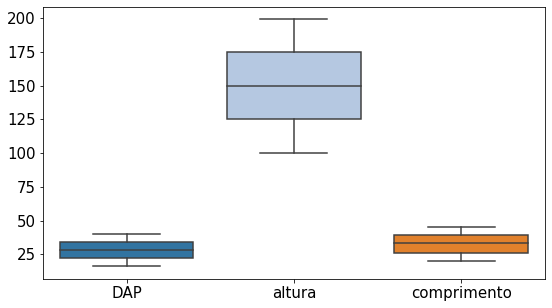

In [16]:
plt.figure(figsize=(9,5))
sns.boxplot(data=dataTBI[['DAP', 'altura', 'comprimento']], palette='tab20')

In [17]:
dataTBI.corr()

,DAP,comprimento,altura,CQE,UM
DAP,1.000000,-0.019853,-0.002907,-0.019064,0.991337
comprimento,-0.019853,1.000000,-0.007945,0.977637,-0.099785
altura,-0.002907,-0.007945,1.000000,0.185033,-0.014252
CQE,-0.019064,0.977637,0.185033,1.000000,-0.100708
UM,0.991337,-0.099785,-0.014252,-0.100708,1.000000


Text(0.5, 0, 'CQEC')

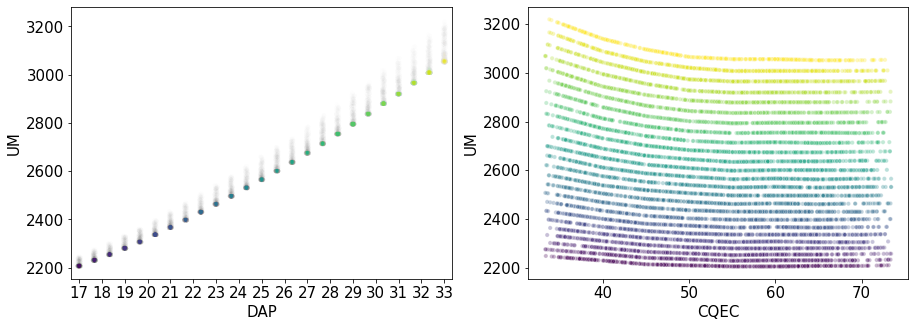

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.stripplot(dataTBI['DAP'], 'UM', data=dataTBI, palette='viridis', alpha=0.005, ax=ax[0])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(20))
sns.scatterplot('CQE', 'UM', data=dataTBI, hue='DAP',palette='viridis', alpha=0.3, size=10, ax=ax[1], legend=False)
ax[1].set_xlabel('CQEC')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,7), dpi=100)
sns.scatterplot(dataTBI['CQE'], dataTBI['UM'], color='darksalmon', lw=2, alpha=0.05, label='Simulação', ax=ax[0])
sns.scatterplot(realizados['CQE'], realizados['UM'], color='black', marker='.', s=100, label='Dados Clínicos', ax=ax[0])
ax[0].legend(loc=0)

sns.scatterplot(dataTBI['DAP'], dataTBI['UM'], color='darksalmon', lw=3, alpha=0.05, label='Simulação', ax=ax[1])
sns.scatterplot(realizados['DAP'], realizados['UM'], color='black',marker='.', s=100, label='Dados Clínicos', ax=ax[1])
ax[1].legend(loc=0)

## Fitando os dados de simulação

In [20]:
def previsionUM(x, a, b, c):
    return a*np.exp(b*x + c*x**2)

In [21]:
popt=pd.Series([])
pcov=pd.Series([])
for i in np.arange(dataTBI['DAP'].min(),dataTBI['DAP'].max()+1):
    try: 
        xdata=dataTBI[dataTBI['DAP']==i]['CQE']
        ydata=dataTBI[dataTBI['DAP']==i]['UM']

        popt[i]=curve_fit(previsionUM, xdata, ydata, p0=[0,0.0001,0.00001])[0]
        pcov[i]=curve_fit(previsionUM, xdata, ydata, p0=[0,0.0001,0.00001])[1]
        #print('.', end=' ')
        #print('DAP: {} (V)'.format(i))
        
    except ValueError:
        print('DAP: {} (X)'.format(i))

/home/pedrocoelho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/home/pedrocoelho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


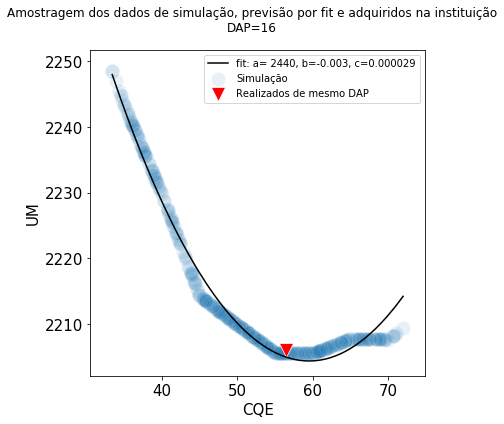

In [22]:
j=16
fig=plt.figure(figsize=(6,6))
fig.suptitle('Amostragem dos dados de simulação, previsão por fit e adquiridos na instituição\nDAP={}'.format(j))
sns.lineplot(dataTBI[dataTBI['DAP']==j]['CQE'],
             previsionUM(dataTBI[dataTBI['DAP']==j]['CQE'], *popt[j]),
             color='black',
             label='fit: a=%5.f, b=%.3f, c=%.6f' % tuple(popt[j]))
sns.scatterplot(dataTBI[dataTBI['DAP']==j]['CQE'],
             dataTBI[dataTBI['DAP']==j]['UM'],
             alpha=0.1, s=200, label='Simulação')
sns.scatterplot(realizados[realizados['DAP']==j]['CQE'], realizados[realizados['DAP']==j]['UM'], marker='v', s=200, color='red', label='Realizados de mesmo DAP')

In [23]:
a=[]
b=[]
c=[]
for i in popt.index:
    a.append(popt[i][0])
    b.append(popt[i][1])
    c.append(popt[i][2])

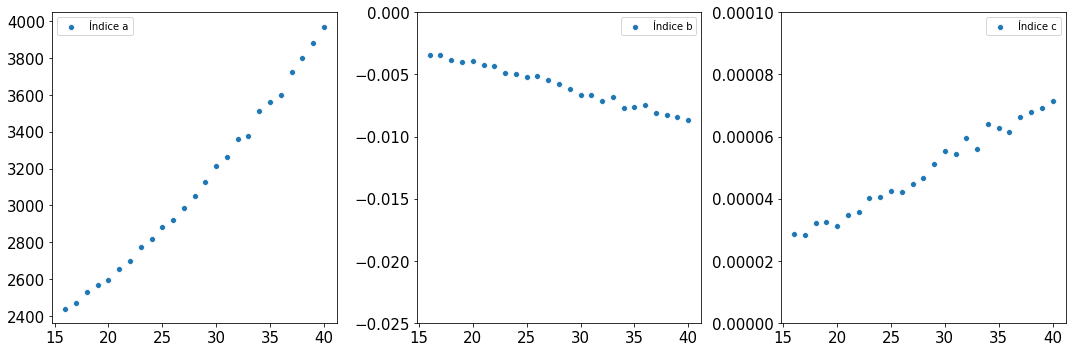

In [24]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(popt.index, a, label='Índice a', ax=ax[0])
sns.scatterplot(popt.index, b, label='Índice b', ax=ax[1])
sns.scatterplot(popt.index, c, label='Índice c', ax=ax[2])
ax[1].set_ylim(-0.025,0)
ax[2].set_ylim(0,0.0001)
plt.tight_layout()

## Fitando os dados dos indices dos fits (a,b,c,d)

In [25]:
def linear(x, a, b):
    return a*x + b

In [26]:
def quadrado(x, a, b, c):
    return a*x**2 + b*x + c

In [27]:
for i in popt.index:
    A=curve_fit(quadrado, popt.index, a)[0]
    B=curve_fit(linear, popt.index, b)[0]
    C=curve_fit(linear, popt.index, c)[0]

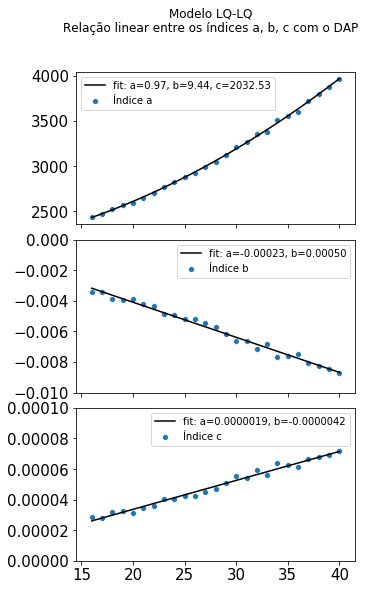

In [28]:
fig, ax = plt.subplots(3, sharex=True, figsize=(5,9), gridspec_kw={'hspace': .1})
fig.suptitle('Modelo LQ-LQ\nRelação linear entre os índices a, b, c com o DAP')
ax[1].set_ylim(-0.010,0)
ax[2].set_ylim(0,0.0001)
sns.scatterplot(popt.index, a, label='Índice a', ax=ax[0])
sns.lineplot(popt.index,
             quadrado(popt.index, *A),
             label='fit: a=%.2f, b=%.2f, c=%.2f' % tuple(A),
             color='black', ax=ax[0])

sns.scatterplot(popt.index, b, label='Índice b', ax=ax[1])
sns.lineplot(popt.index,
             linear(popt.index, *B),
             label='fit: a=%.5f, b=%.5f' % tuple(B),
             color='black', ax=ax[1])

sns.scatterplot(popt.index, c,label='Índice c', ax=ax[2])
sns.lineplot(popt.index,
             linear(popt.index, *C),
             label='fit: a=%.7f, b=%.7f' % tuple(C),
             color='black', ax=ax[2])

plt.savefig('LQ-LQ.png', dpi=300)

In [29]:
pd.DataFrame({'DAP':popt.index,
             'a':a, 'b':b, 'c':c},
            columns=['DAP', 'a', 'b', 'c']).corr()

,DAP,a,b,c
DAP,1.000000,0.994724,-0.993353,0.991040
a,0.994724,1.000000,-0.994288,0.992761
b,-0.993353,-0.994288,1.000000,-0.999743
c,0.991040,0.992761,-0.999743,1.000000


In [30]:
pd.DataFrame({'DAP':popt.index,
             'a':a, 'b':b, 'c':c},
            columns=['DAP', 'a', 'b', 'c']).cov()

,DAP,a,b,c
DAP,54.166667,3465.846958,-1.242193e-02,1.025635e-04
a,3465.846958,224120.511196,-7.997829e-01,6.608776e-03
b,-0.012422,-0.799783,2.886945e-06,-2.388599e-08
c,0.000103,0.006609,-2.388599e-08,1.977294e-10


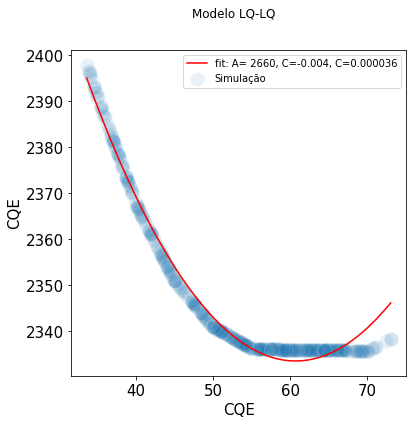

In [31]:
j=21
x=dataTBI[dataTBI['DAP']==j]['CQE']
fig=plt.figure(figsize=(6,6))
#fig.suptitle('Amostragem dos dados de simulação, previsão por fit e adquiridos na instituição\nDAP={}'.format(j))
fig.suptitle("Modelo LQ-LQ")
#sns.lineplot(x,
#             previsionUM(x, *popt[j]),
#             color='black',
#             label='fit: a=%5.f, b=%.3f, c=%.6f' % tuple(popt[j]))
sns.scatterplot(x,
             dataTBI[dataTBI['DAP']==j]['UM'],
             alpha=0.1, s=200, label='Simulação')
#sns.scatterplot(realizados[realizados['DAP']==j]['CQE'], realizados[realizados['DAP']==j]['UM'], marker='v', s=200, color='red', label='Realizados')
sns.lineplot(x,
                previsionUM(x, quadrado(j, *A), linear(j, *B), linear(j, *C)),
                color='red',
                label='fit: A=%5.f, C=%.3f, C=%.6f' % tuple([quadrado(j, *A), linear(j, *B), linear(j, *C)]))


In [32]:
A,B,C

(array([9.73953603e-01, 9.44346513e+00, 2.03252607e+03]),
 array([-0.00022933,  0.00049759]),
 array([ 1.89348084e-06, -4.20448216e-06]))

## Analisando os dados da instituição com o modelo estabelecido

Lembre que os dados da instituição estão armazenados no DataFrame: realizados \\\
Os dados de simulação estão armazenados em \\\
A equação encontrada pode ser obtida por meio da relação:\\\
previsionUM(x,linear(j, *A).round(0), linear(j, *B).round(6), linear(j, *C).round(7), linear(j, *D).round(8))\\\
-->no qual x=dataTBI[dataTBI['DAP']==j]['CQE'] \\\
-->j a escolha do CQE de interesse

In [33]:
UMexact=[]
for i in realizados.index:
    UMexact.append(monitor_unit(100,465,realizados['DAP'][i],realizados['altura'][i],realizados['comprimento'][i]))
    
realizados['UM exact']=UMexact

In [34]:
UMest=[]
for i in realizados.index:
    cqe=realizados['CQE'][i]
    dap=realizados['DAP'][i]
    UMest.append(previsionUM(cqe,quadrado(dap, *A), linear(dap, *B), linear(dap, *C)))
    
realizados['UM est']=UMest

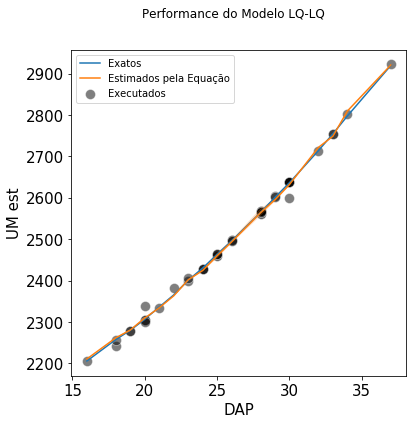

In [35]:
fig=plt.figure(figsize=(6,6))
fig.suptitle('Performance do Modelo LQ-LQ')
sns.scatterplot(realizados['DAP'], realizados['UM'], data=realizados, label='Executados', color='black', s=100, alpha=.5)
sns.lineplot(realizados['DAP'], realizados['UM exact'], data=realizados, label='Exatos')
sns.lineplot(realizados['DAP'], realizados['UM est'], data=realizados, label='Estimados pela Equação')

plt.savefig('LQ-LQ-realizados.png', dpi=300)

In [36]:
realizados.to_csv('realizados_LQ-LQ.csv')